# VariantNet

VariantNet is a small neural network that makes variant calls from aggregated alignment information. Unlike DeepVariant (http://www.biorxiv.org/content/early/2016/12/14/092890), we don't construct pile-up images and send the images to Google's DistBelief for computation. Instead, the alignments in a BAM file are converted to three 15 by 4 matrices for training the network and calling variants. 

The first matrix simple encode the expected reference sequence using one-hot-like encoding.  For a candidate variant site, we padded 7 bases both on the right and the left. The number of reads that aligned to a reference position is encoded in the first matrices. The 2nd matrix encode the difference of all the bases observed in the read-reference alignment before a reference location to the expected observations (= the first matrix).  The 3rd matrix is similar to the 2nd matrix, expect none of the insertion bases in the reads are counted. (We will show an example below.)

The neural network used for training for calling variants contains two convolution/maxpool layer. We avoid operations that does not maintain the symmetry of the 4 different bases. For example, the max pool layers only appllyto different locations but not mix a subset of bases. And the convolution filters apply on 4 bases at the same time.  After the two convolution layers, we add four full connected layers.  

The output layer contains four groups of outputs. The first group (4 units) is to fit the reference base.  The second group (5 units) is to fit the variant base.  The third output group (2 units) is to learn whether the variant is a heterozygous or a homozygous one. The final output group (6 units) is for inferring the variation types (SNP, simple-deletion, simple-insertion, no-variant, complicated-deletion, and complicated-insertion).


## Training and testing data

We take a NA12878 PacBio read dataset generated by WUSTL (https://www.ncbi.nlm.nih.gov//bioproject/PRJNA323611) and align to GRCh38 with `bwa mem`. We train the NN using calling on a SNP call set generated by GIAB project (ftp://ftp-trace.ncbi.nlm.nih.gov:/giab/ftp/release/NA12878_HG001/NISTv3.3.2/GRCh38). Like all short-read-based call set, there are a lot of region in the human genome that the short reads can not be aligned properly to call SNPs.  We only training on those high confident regions.  However, with PacBio read length and non-systematic random error, once we have trained a variant caller, we should be able to apply the caller for some more difficult regions to call SNPs more comprehensively in a genome.

As a proof of principle, we only train using the calls on chromosome 21 and test on chromosome 22.

This simple work results from an exercise to get my feet wet learning neutral network beyond just knowing the theories. It also shows a simple neural network rather than a big one can already help for solving some simple but relative interesting problems in genomics. 


July 28, 2017

Jason Chin

In [1]:
# for plotting to visualize some data
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# I have not written a python packaging script, load the NN class within the repository
import sys
sys.path.append('../')

In [3]:
#import variantNet as vn
import variantNet.utils as utils
import variantNet.vn as vn

In [4]:
# useful for testing
#reload(utils)
#reload(vn)

Shell script example to get testing data from BAM files and (stripped) VCF files
These scripts depend on `falcon_kit.FastaReader` for reading fasta files and `samtools` for parsing alignment records. 

```
mkdir -p ./wd
cd ./wd
python ../helper_scripts/get_SNP_candidates.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                               --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                               --pm_count_fn pm_counts_chr22 --ctg_nam chr22
python ../helper_scripts/get_alignment_tensor.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                                 --pm_count_fn pm_counts_chr22 \
                                                 --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                                 --ctg_name chr22 > aln_tensor_chr22
python ../helper_scripts/get_variant_set.py < ../testing_data/chr22/chr22.vcf > variants_chr22
```

You can download the initial alignment files and vcf files from https://www.dropbox.com/s/fwyvu24hdxqv06i/VariantNet_testing_data.tgz and you can get a pre-generated dataset file for training and evaluation from  https://www.dropbox.com/s/745m7mhzkj3rx28/VariantNet_wd.tgz. (Not sure how long I will be hosting those files though.)

## Training using Chr21 variant calls

In [5]:
# load the generate alignment "tensors" 
# we don't use the variats outside the regions defined in `CHROM21_v.3.3.2_highconf_noinconsistent.bed`

Xarray, Yarray, pos_array = \
utils.get_training_array("../wd/aln_tensor_chr21", 
                         "../wd/variants_chr21", 
                         "../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed" )

In [6]:
print Xarray.shape
print Yarray.shape

(89064, 15, 4, 3)
(89064, 17)


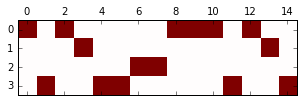

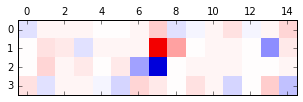

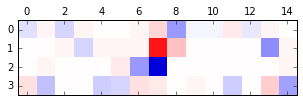

In [7]:
# here we show how the three matrices are like for a candidate site

i = 999
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,0].transpose(), vmin=-50, vmax=50, cmap=cm.seismic, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.seismic, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.seismic, fignum=0)

In [8]:
%%bash
mkdir -p ../wd/parameters

In [9]:
# create a VariantNet
vnn = vn.VariantNet()

In [10]:
# initialize the parameters
vnn.init()

In [11]:
# training and save the parameters, we train on the first 30000 SNP sites and validate on other 10000 SNP sites
batch_size = 500
validation_lost = []
train_set = Xarray[:70000], Yarray[:70000]
val_set = Xarray[70000:80000], Yarray[70000:80000]
for i in range(2501):
    Xbatch, Ybatch = utils.get_batch(train_set[0], train_set[1], size=batch_size)
    loss = vnn.train(Xbatch, Ybatch)
    if i % (len(train_set[0])/batch_size) == 0:
        v_lost = vnn.get_loss( val_set[0], val_set[1] )
        print i, "train lost:", loss/batch_size, "validation lost", v_lost/len(val_set[0])
        vnn.save_parameters('../wd/parameters/vn.params-%04d' % i)
        validation_lost.append( (v_lost, i) )
        

0 train lost: 6.85353564453 validation lost 4.7939609375
140 train lost: 0.903034667969 validation lost 0.731593408203
280 train lost: 0.423625 validation lost 0.414962060547
420 train lost: 0.28067779541 validation lost 0.316130224609
560 train lost: 0.294117767334 validation lost 0.268815209961
700 train lost: 0.366343505859 validation lost 0.272526196289
840 train lost: 0.342458770752 validation lost 0.243535498047
980 train lost: 0.138230560303 validation lost 0.236549462891
1120 train lost: 0.258131622314 validation lost 0.228572070312
1260 train lost: 0.106848670959 validation lost 0.232079248047
1400 train lost: 0.106435501099 validation lost 0.228581494141
1540 train lost: 0.154901550293 validation lost 0.219208813477
1680 train lost: 0.206346862793 validation lost 0.225836132813
1820 train lost: 0.0664565582275 validation lost 0.227346679687
1960 train lost: 0.0841209182739 validation lost 0.228929003906
2100 train lost: 0.0853759994507 validation lost 0.230304638672
2240 trai

In [12]:
# pick the parameter set of the smallest validation loss

validation_lost.sort()
i = validation_lost[0][1]
print i
vnn.restore_parameters('../wd/parameters/vn.params-%04d' % i)

1540
INFO:tensorflow:Restoring parameters from ../wd/parameters/vn.params-1540


## Testing using Chr22 variant calls

In [13]:
Xarray2, Yarray2, pos_array2 = \
utils.get_training_array("../wd/aln_tensor_chr22", 
                         "../wd/variants_chr22", 
                         "../testing_data/chr22/CHROM22_v.3.3.2_highconf_noinconsistent.bed" )

In [14]:
all_t = []
for i in xrange(0,len(Xarray2),10000):
    Y1, Y2, Y3, Y4= vnn.predict(Xarray2[i:i+10000])
    #all_t.append(np.concatenate( (Y3,Y4) , 1  ) )
    all_t.append(np.concatenate( (Y3,Y4) , 1  ) )
all_t = np.concatenate(all_t)
t = all_t

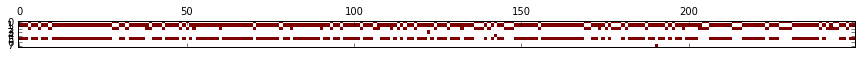

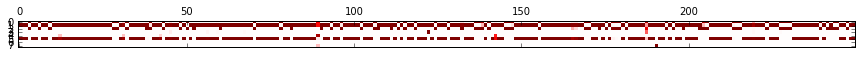

In [15]:
# we can compare the output of the expected calls and the predicted calls

figure(figsize=(15, 5))
matshow(Yarray2[4000:4250,9:].transpose(), cmap=cm.seismic, fignum=0, vmin=-1, vmax=1)
figure(figsize=(15, 5))
matshow(t[4000:4250,:].transpose(), cmap=cm.seismic, fignum=0, vmin=-1, vmax=1)
figure(figsize=(15, 5))


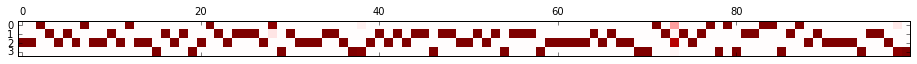

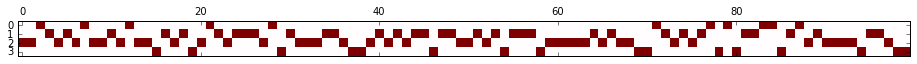

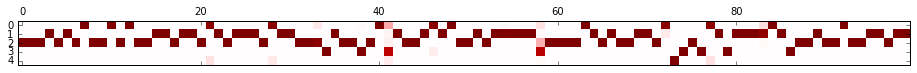

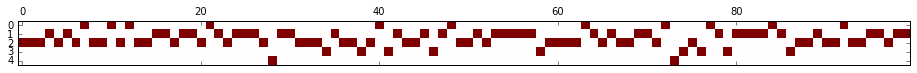

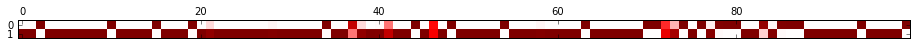

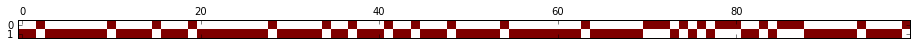

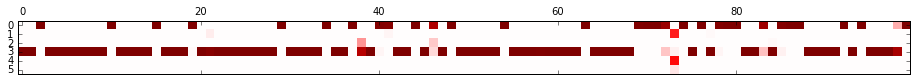

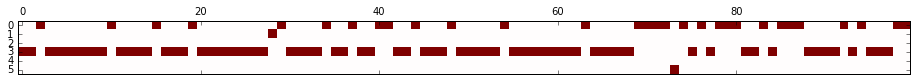

In [16]:
Y1, Y2, Y3, Y4= vnn.predict(Xarray2[210:550])
matshow(Y1[0:100].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Yarray2[210:210+100,0:4].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Y2[0:100].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Yarray2[210:210+100,4:9].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Y3[0:100].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Yarray2[210:210+100,9:11].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Y4[0:100].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)
matshow(Yarray2[210:210+100,11:].transpose(), cmap=cm.seismic, vmin=-1, vmax=1)

## Quick Evaluation

In [17]:
evaluation_data = []
for pos, predict_v, annotate_v in zip(np.array(pos_array2), t[:,:2], Yarray2[:,9:11]):
    evaluation_data.append( (pos, np.argmax(predict_v), np.argmax(annotate_v)) )
evaluation_data = np.array(evaluation_data)

evaluation_data2 = []
for pos, predict_v, annotate_v in zip(np.array(pos_array2), t[:,2:], Yarray2[:,11:]):
    evaluation_data2.append( (pos, np.argmax(predict_v), np.argmax(annotate_v)) )
evaluation_data2 = np.array(evaluation_data2)

In [18]:
from collections import Counter

In [19]:
# check het-hom confusion matrix
for i in range(2):
    cnt = Counter(evaluation_data[evaluation_data[:,2]==i,1])
    for j in range(2):
        print cnt.get(j,0),"\t",
    print

22839 	1820 	
346 	88063 	


In [20]:
# check variant type confusion matrix
for i in range(6):
    cnt = Counter(evaluation_data2[evaluation_data2[:,2]==i,1])
 
    for j in range(6):
        print cnt.get(j,0),"\t",
    print
ed = np.array(evaluation_data)
ed2 = np.array(evaluation_data2)

28112 	23 	4 	541 	0 	0 	
33 	534 	1 	407 	31 	1 	
12 	0 	535 	99 	0 	17 	
214 	84 	174 	81439 	17 	13 	
3 	46 	1 	53 	137 	8 	
0 	19 	173 	23 	22 	292 	


In [21]:


print "--- het recall"
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) & (ed[:,2]==0) ) / sum( (ed2[:,2] == 0) & (ed[:,2]==0) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) & (ed[:,2]==0) ) / sum( (ed2[:,2] == 1) & (ed[:,2]==0) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) & (ed[:,2]==0) ) / sum( (ed2[:,2] == 2) & (ed[:,2]==0) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) & (ed[:,2]==0) ) / sum( (ed2[:,2] != 3) & (ed[:,2]==0) )

print "--- het ppv"
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) & (ed[:,1]==0) ) / sum( (ed2[:,1] == 0) & (ed[:,1]==0) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) & (ed[:,1]==0) ) / sum( (ed2[:,1] == 1) & (ed[:,1]==0) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) & (ed[:,1]==0) ) / sum( (ed2[:,1] == 2) & (ed[:,1]==0) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) & (ed[:,1]==0) ) / sum( (ed2[:,1] != 3) & (ed[:,1]==0) )


print "--- hom recall "
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) & (ed[:,2]==1) ) / sum( (ed2[:,2] == 0) & (ed[:,2]==1) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) & (ed[:,2]==1) ) / sum( (ed2[:,2] == 1) & (ed[:,2]==1) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) & (ed[:,2]==1) ) / sum( (ed2[:,2] == 2) & (ed[:,2]==1) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) & (ed[:,2]==1) ) / sum( (ed2[:,2] != 3) & (ed[:,2]==1) )

print "--- hom ppv "
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) & (ed[:,1]==1) ) / sum( (ed2[:,1] == 0) & (ed[:,1]==1) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) & (ed[:,1]==1) ) / sum( (ed2[:,1] == 1) & (ed[:,1]==1) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) & (ed[:,1]==1) ) / sum( (ed2[:,1] == 2) & (ed[:,1]==1) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) & (ed[:,1]==1) ) / sum( (ed2[:,1] != 3) & (ed[:,1]==1) )

print "--- all recall"
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) ) / sum( (ed2[:,2] == 0) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) ) / sum( (ed2[:,2] == 1) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) ) / sum( (ed2[:,2] == 2) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) ) / sum( (ed2[:,2] != 3) )


print "--- all ppv"
print "       SNP", 1.0 * sum( (ed2[:,1] == 0) & ( ed2[:,2] == 0 ) ) / sum( (ed2[:,1] == 0) )
print "simple-DEL", 1.0 * sum( (ed2[:,1] == 1) & ( ed2[:,2] == 1 ) ) / sum( (ed2[:,1] == 1) )
print "simple-INS", 1.0 * sum( (ed2[:,1] == 2) & ( ed2[:,2] == 2 ) ) / sum( (ed2[:,1] == 2) )
print "       ALL", 1.0 * sum( (ed2[:,1] != 3) & ( ed2[:,2] != 3 ) ) / sum( (ed2[:,1] != 3) )

--- het recall
       SNP 0.976999231885
simple-DEL 0.361016949153
simple-INS 0.681978798587
       ALL 0.960257918002
--- het ppv
       SNP 0.991108190977
simple-DEL 0.738317757009
simple-INS 0.512820512821
       ALL 0.991736256089
--- hom recall 
       SNP 0.99447197865
simple-DEL 0.769784172662
simple-INS 0.9
       ALL 0.977891156463
--- hom ppv 
       SNP 0.989357864358
simple-DEL 0.75959933222
simple-INS 0.606595995289
       ALL 0.958477508651
--- all recall
       SNP 0.98019525802
simple-DEL 0.530287984111
simple-INS 0.806938159879
       ALL 0.96392199698
--- all ppv
       SNP 0.990766194403
simple-DEL 0.756373937677
simple-INS 0.602477477477
       ALL 0.983544220809


We acutally call more variants outside those "high confidence" (a short alignment concept) regions, e.g., CYP2D6 regions in chr22.

In [22]:
Xarray3, pos_array3 = utils.get_aln_array("../wd/aln_tensor_chr22")
print Xarray3.shape

(159929, 15, 4, 3)


In [23]:
all_t = []
for i in xrange(0,len(Xarray3),10000):
    Y1, Y2, Y3, Y4= vnn.predict(Xarray3[i:i+10000])
    all_t.append(np.concatenate( (Y3,Y4) , 1  ) )
all_t = np.concatenate(all_t)
t = all_t

In [24]:
evaluation_data3 = []
for pos, predict_v in zip(np.array(pos_array3), t[:,2:]):
    evaluation_data3.append( (pos, np.argmax(predict_v), np.argmax(annotate_v)) )
evaluation_data3 = np.array(evaluation_data3)
print "Total number of variant from the high-confident short-read call-set: ", sum(ed2[:,1]!=3)
print "Total number of variant calls from our chr22 data: ", sum(evaluation_data3[:,1] != 3)

Total number of variant from the high-confident short-read call-set:  30506
Total number of variant calls from our chr22 data:  44684
